In [1]:
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import quickshift

sys.path.append("../src")
import exlib
from exlib.datasets.chestx import *
from exlib.datasets.cholec import *
from exlib.features.vision import *
from exlib.explainers.archipelago import *

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cholec_dataset = CholecDataset(split="test")
image = cholec_dataset[0]["image"]
image_np = image.numpy().transpose(1,2,0)

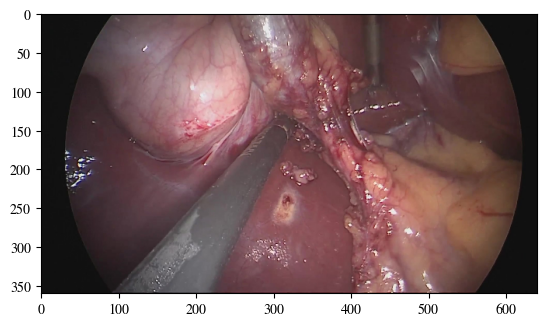

In [3]:
plt.clf()
plt.imshow(image_np)

In [4]:
model = torchvision.models.resnet50(pretrained=True).eval()
model_wrapper = ModelWrapperTorch(model, "cpu")

In [5]:
with torch.no_grad():
    predictions = model_wrapper(np.expand_dims(image_np,0))
    class_idx = predictions[0].argsort()[::-1][0]

In [16]:
baseline = np.zeros_like(image_np)
segments = quickshift(image_np, kernel_size=5, max_dist=300, ratio=0.2, sigma=100)

In [18]:
xf = ImageXformer(image_np, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)


In [19]:
class_idx

435

In [20]:
inter_effects, main_effects = apgo.explain(top_k=2, separate_effects=True)

> /home/antonxue/foo/exlib/src/exlib/explainers/libs/archipelago/explainer.py(289)search_feature_sets()
    287                 except:
    288                     import pdb; pdb.set_trace()
--> 289                     numerator[np.abs(numerator) / np.min(np.abs(np.array([f_a, f_b, f_c, f_d]))) < 1e-5] = 0.0
    290 
    291                 # if denominator == 0.0:



ipdb>  c


TypeError: 'numpy.float32' object does not support item assignment

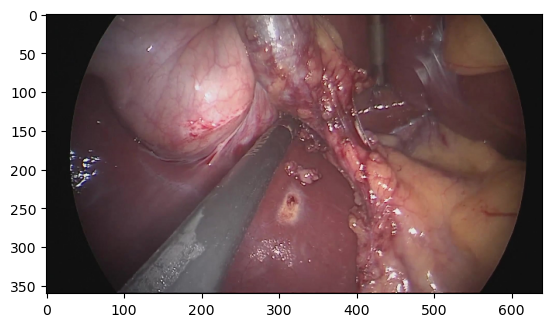

In [4]:
plt.clf()
plt.imshow(image.numpy().transpose(1,2,0))

In [5]:
patch_groups = PatchGroups(patch_size=(32,32), flat=True)
qshift_groups = QuickshiftGroups(max_segs=8, kernel_size=8, flat=True)
watershed_groups = WatershedGroups(max_segs=8, flat=True)
sam_groups = SamGroups(max_segs=32, flat=True)
id_groups = IdentityGroups(flat=True)
rand_groups = RandomGroups(flat=True)

In [6]:
G_qshift = qshift_groups(image[None,...])
G_qshift_np = G_qshift[0].numpy()
G_qshift.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7])

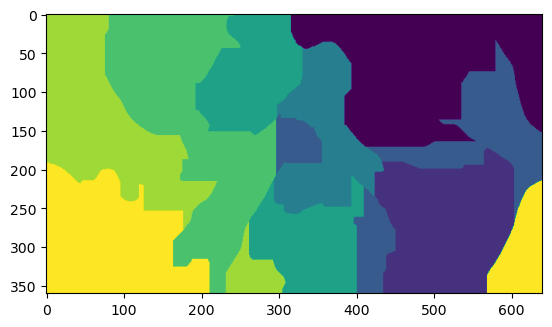

In [7]:
plt.clf()
plt.imshow(G_qshift_np)

In [8]:
G_water = watershed_groups(image[None,...])
G_water_np = G_water[0].numpy()
G_water.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7])

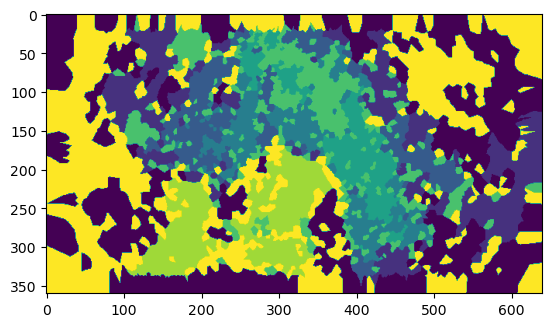

In [9]:
plt.clf()
plt.imshow(G_water_np)

In [10]:
G_sam = sam_groups(image[None,...])
G_sam_np = G_sam[0].numpy()
G_sam.unique()

xi_np (360, 640, 3), uint8


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

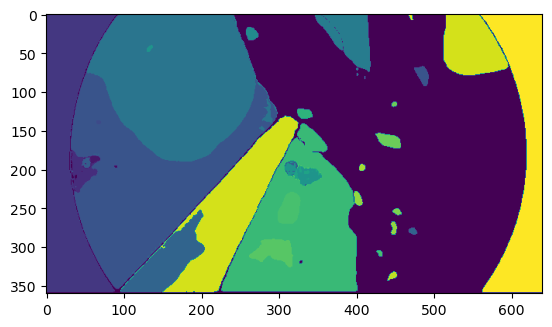

In [11]:
plt.clf()
plt.imshow(G_sam_np)

In [12]:
G_id = id_groups(image[None,...])
G_id_np = G_id[0].numpy()
G_id.unique()

tensor([0.])

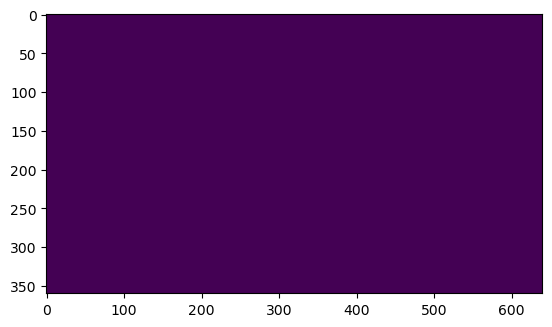

In [13]:
plt.clf()
plt.imshow(G_id_np)

In [14]:
G_rand = rand_groups(image[None,...])
G_rand_np = G_rand[0].numpy()
G_rand.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

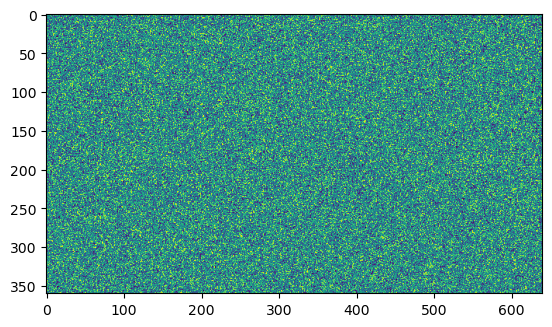

In [15]:
plt.clf()
plt.imshow(G_rand_np)

In [16]:
# metric = ChestXMetric()
# metric = CholecMetric()

In [17]:
Gt = torch.randint(0,2,(7,30,256,256))
Gp = torch.randint(0,2,(7,50,256,256))

In [18]:
# bm_score = metric(Gt.cuda(), Gp.cuda(), big_batch=True)
# bm_score.shape

In [19]:
# nb_score = metric(Gt.cuda(), Gp.cuda(), big_batch=False)
# nb_score.shape